In [39]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

1.13.2


In [40]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [41]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9259279177577649894
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4511478295002572762
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7711549031
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6242990844516024339
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5587878164551091899
physical_device_desc: "device: XLA_GPU device"
]


## Load sample data

In [42]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [43]:
X = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/images/*.tif'))
Y = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 292/292 [00:01<00:00, 205.56it/s]


In [44]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


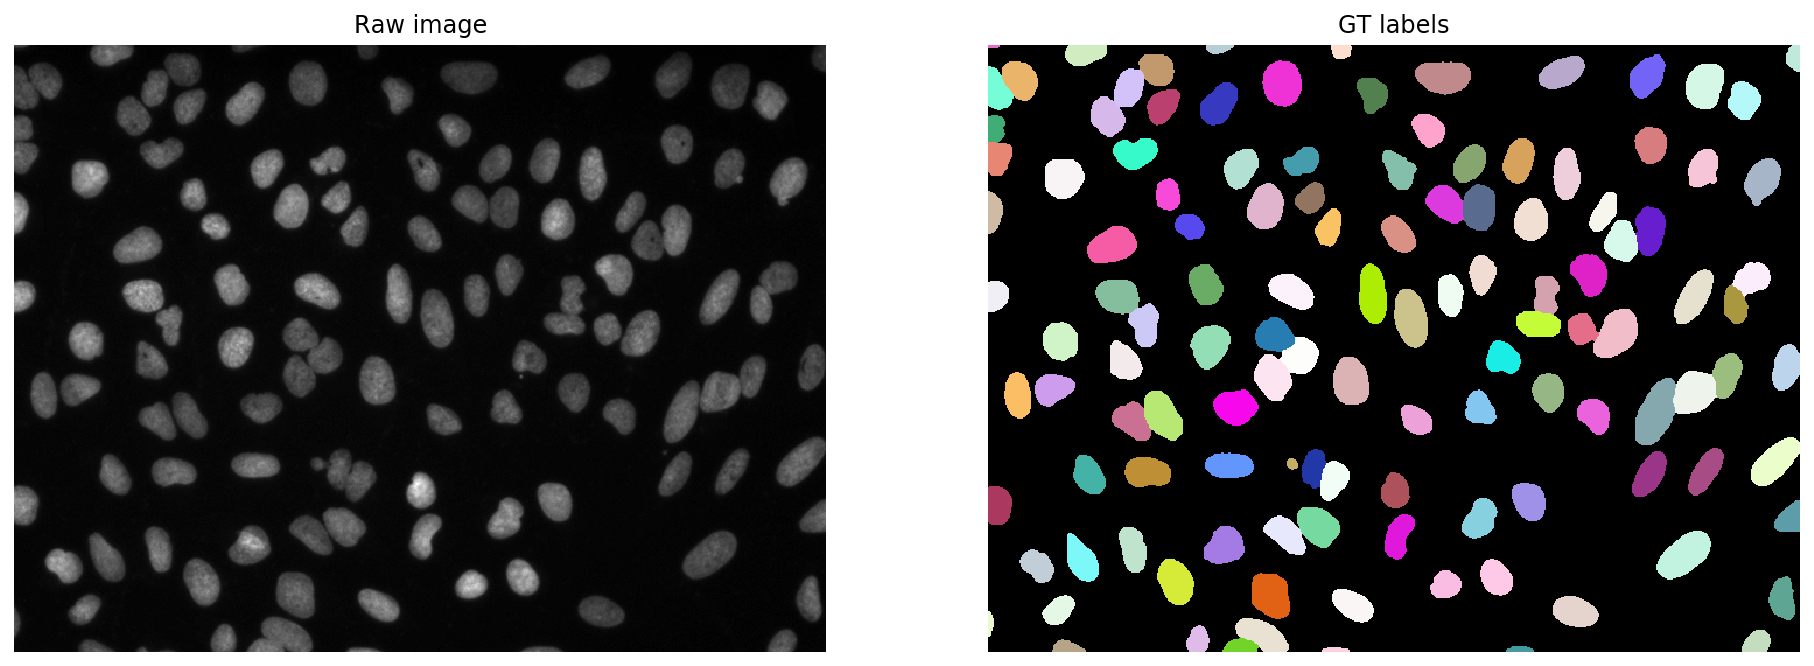

In [45]:
i = 5
# img, lbl = X[i], Y[i]
img, lbl = X_val[i], Y_val[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [46]:
img.shape

(520, 696)

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [48]:
import cv2
from albumentations import *

In [49]:
ranf=list(np.random.ranf(8)/5)
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=(0.0, 1.2), rotate_limit=10, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, always_apply=False, p=1),
    CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=1),
    GaussNoise(var_limit=(0.0, 0.15), mean=0, always_apply=False, p=0.5),
    GaussianBlur(blur_limit=33, p=0.5),
    ElasticTransform(alpha=100, sigma=7, alpha_affine=1, p=0.7, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
], p=0.95)

## Train with augmentations

In [51]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = n_channel,
    train_batch_size = 8, 
    train_epochs = 400,
    train_steps_per_epoch = 200,
    train_one_cycle_lr_max = None,
    train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-5},
    train_loss_weights=(1, 0.2),
    unet_dropout=0.2,
    train_foreground_only=0.99,
    y_range = None,
    norm_by_mask=False,
#     train_background_reg=0.0005,  #instead of 0.0001
#     train_learning_rate=0.008
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), norm_by_mask=False, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.99, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-05}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.2, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False, 

In [52]:
model = StarDist2D(conf, name='stardist', basedir='AUGA8_b8_lossw0.2_drop0.2_FG0.99_csbsub1')

ValueError: Invalid configuration of type 'Config2D', was expecting type 'Config2D'.

In [26]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN, multi=True, ncpu=8)

Epoch 1/400
200/200 [==============================] - 35s 176ms/step - loss: 2.3023 - prob_loss: 0.2404 - dist_loss: 10.3096 - prob_kld: 0.1656 - dist_relevant_mae: 10.3040 - dist_relevant_mse: 218.0804 - val_loss: 1.5027 - val_prob_loss: 0.1644 - val_dist_loss: 6.6913 - val_prob_kld: 0.0774 - val_dist_relevant_mae: 6.6884 - val_dist_relevant_mse: 97.3159
- OneCycleScheduler, lr: 0.00012049345203519763
Epoch 2/400
200/200 [==============================] - 33s 166ms/step - loss: 1.4025 - prob_loss: 0.1168 - dist_loss: 6.4288 - prob_kld: 0.0425 - dist_relevant_mae: 6.4258 - dist_relevant_mse: 119.1542 - val_loss: 0.9037 - val_prob_loss: 0.1225 - val_dist_loss: 3.9059 - val_prob_kld: 0.0355 - val_dist_relevant_mae: 3.9030 - val_dist_relevant_mse: 36.1217
- OneCycleScheduler, lr: 0.0001219734699534139
Epoch 3/400
200/200 [==============================] - 34s 169ms/step - loss: 1.0133 - prob_loss: 0.0951 - dist_loss: 4.5911 - prob_kld: 0.0203 - dist_relevant_mae: 4.5883 - dist_relevant_m

Probably due to custom activation function (lambda function), not be able to save model

In [23]:
# model.keras_model.save('1b_100s_400e.h5') 

# model.keras_model.load_weights('1b_100s_400e.h5')

# model.keras_model.summary()

In [11]:
idx

[3]

In [12]:
# the output from the sample_patches is also a list..... so basically we turn a list of list into a n-dim array
arrays = np.hstack([sample_patches((data_train.Y[k],) + data_train.channels_as_tuple(data_train.X[k]),
             patch_size=data_train.patch_size, n_samples=1,
             valid_inds=data_train.get_valid_inds(k)) for k in idx])

In [14]:
type(arrays), arrays.shape

(numpy.ndarray, (2, 1, 256, 256))

In [16]:
X = arrays[1,...,data_train.bb,data_train.bb]  #the elipsis at second dimension is reserved for channels>1, but not really tested
Y = arrays[0,...,data_train.bb,data_train.bb].astype('uint16')
X.shape, Y.shape

((1, 256, 256), (1, 256, 256))

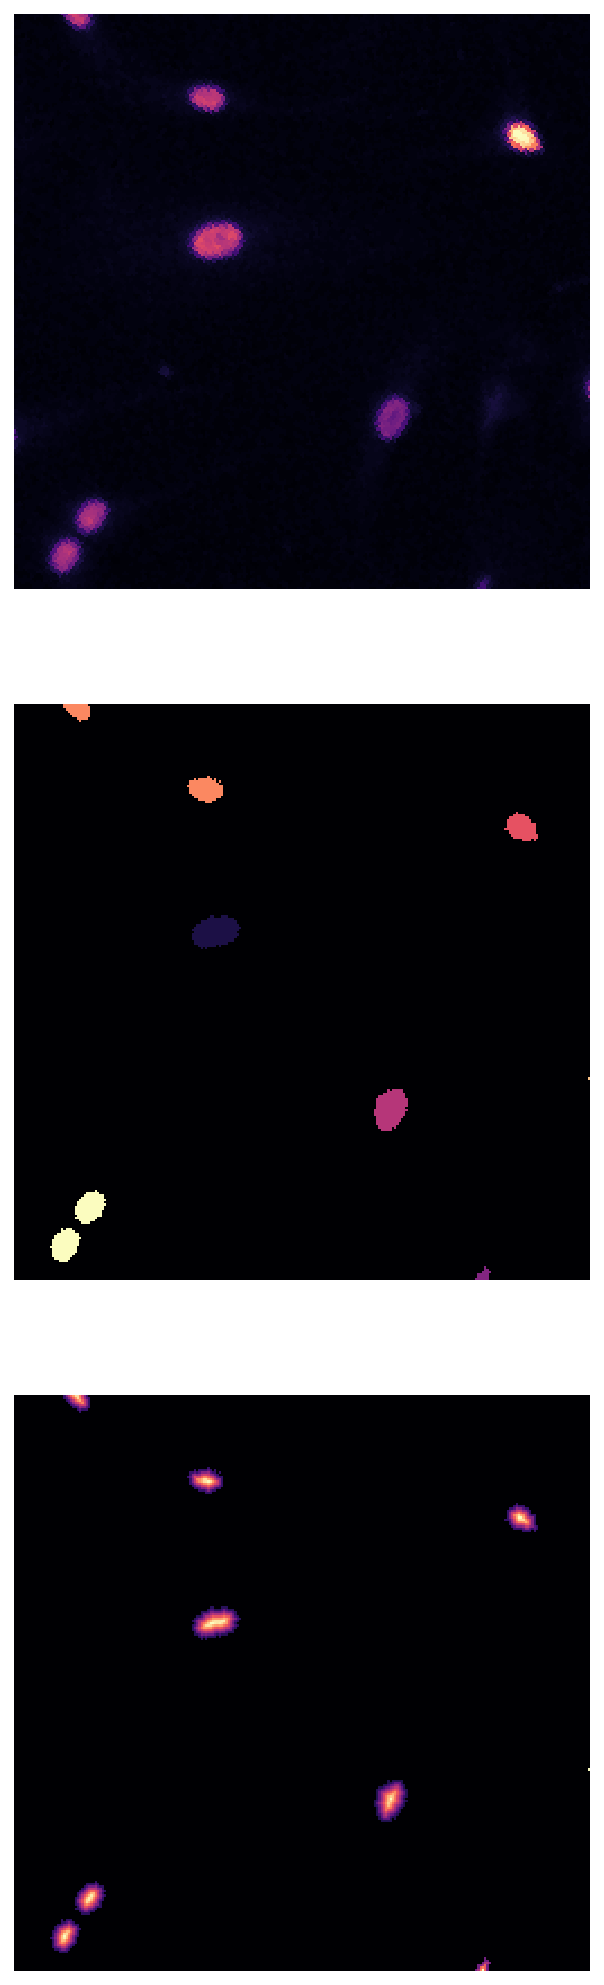

In [18]:
data_train.augmenter = AUGMENTATIONS_TRAIN
XX, YY = zip(*[data_train.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
from stardist.utils import (edt_prob, _normalize_grid) 

prob = np.stack([edt_prob(lbl[data_train.b]) for lbl in YY])
plot_some(XX, YY, prob, x_inch=25, y_inch=18)

In [19]:
from stardist.geometry import star_dist
if data_train.shape_completion:
    Y_cleared = [clear_border(lbl) for lbl in YY]
    dist      = np.stack([star_dist(lbl,data_train.n_rays,mode=data_train.sd_mode)[data_train.b+(slice(None),)] for lbl in Y_cleared])
    dist_mask = np.stack([edt_prob(lbl[data_train.b]) for lbl in Y_cleared])
else:
    dist      = np.stack([star_dist(lbl,data_train.n_rays,mode=data_train.sd_mode) for lbl in YY])
    dist_mask = prob

XX = np.stack(XX)
if XX.ndim == 3: # input image has no channel axis
    XX = np.expand_dims(XX,-1)
    prob = np.expand_dims(prob,-1)
    dist_mask = np.expand_dims(dist_mask,-1)

# subsample wth given grid
dist_mask = dist_mask[data_train.ss_grid]
prob      = prob[data_train.ss_grid]
dist      = dist[data_train.ss_grid]

# return [X,dist_mask], [prob,dist]

In [20]:
dist_mask.shape

(1, 256, 256, 1)

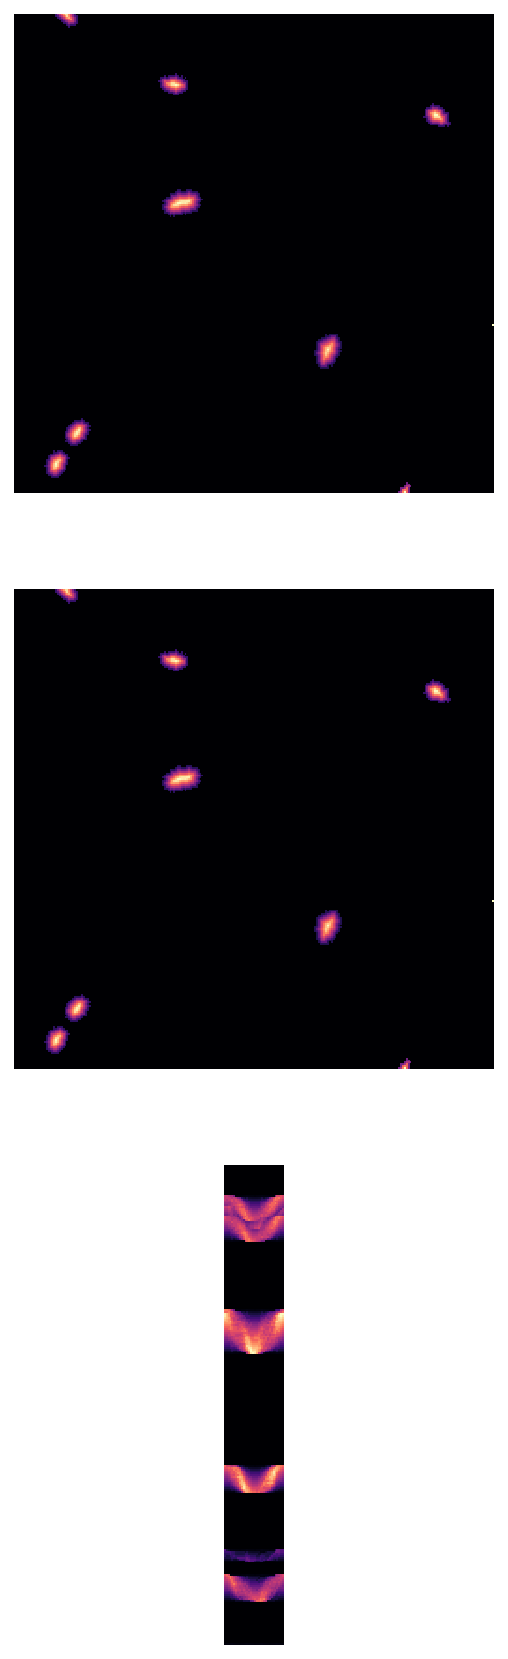

In [21]:
plot_some(dist_mask, prob, dist)

In [22]:
dist.shape  #dist is the star radius of the 32 (n_rays) at each pixel value. 

(1, 256, 256, 32)

In [ ]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=4, n_rays=32, patch_size=(256,256), augmenter=None, shape_completion=False)

In [189]:
# %debug
# data_train[0]

> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(60)<genexpr>()
     58         else:
     59             X, Y = list(zip(*[(np.stack([_x[0] for _x in x],axis=-1)[self.b], y[0]) for y,*x in arrays]))
---> 60 
     61         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     62 



ipdb>  c


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(82)__getitem__()
     80 
     81         # subsample wth given grid
---> 82         dist_mask = dist_mask[self.ss_grid]
     83         prob      = prob[self.ss_grid]
     84         dist      = dist[self.ss_grid]



ipdb>  dist_mask.shape


(4, 256, 256, 1)


ipdb>  help



Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb



ipdb>  EOF


BdbQuit: 

In [ ]:
print(Config2D.__doc__)

In [ ]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 1,  #no gpu
    train_epochs = 400,
    train_steps_per_epoch = 100
)
print(conf)
vars(conf)

In [ ]:
# if use_gpu:
#     from csbdeep.utils.tf import limit_gpu_memory
#     # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
#     limit_gpu_memory(0.8)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [ ]:
%pwd

In [ ]:
model = StarDist2D(conf, name='stardist', basedir='models_test2')

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [ ]:
#skipped temporarily
# median_size = calculate_extents(list(Y), np.median)
# fov = np.array(model._axes_tile_overlap('YX'))
# if any(median_size > fov):
#     print("WARNING: median object size larger than field of view of the neural network.")

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [28]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:14<00:03,  1.09it/s, 0.490 -> 0.889]


Using optimized values: prob_thresh=0.46908, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46907995878230185, 'nms': 0.3}

In [29]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [30]:
model.export_TF(fname='2020-03-25-12-33-24')

## Prediction on Test set

In [31]:
X = sorted(glob('/home/lis-paul/data/centuri/test/images/*.tif'))
X = list(map(imread,X))

In [32]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

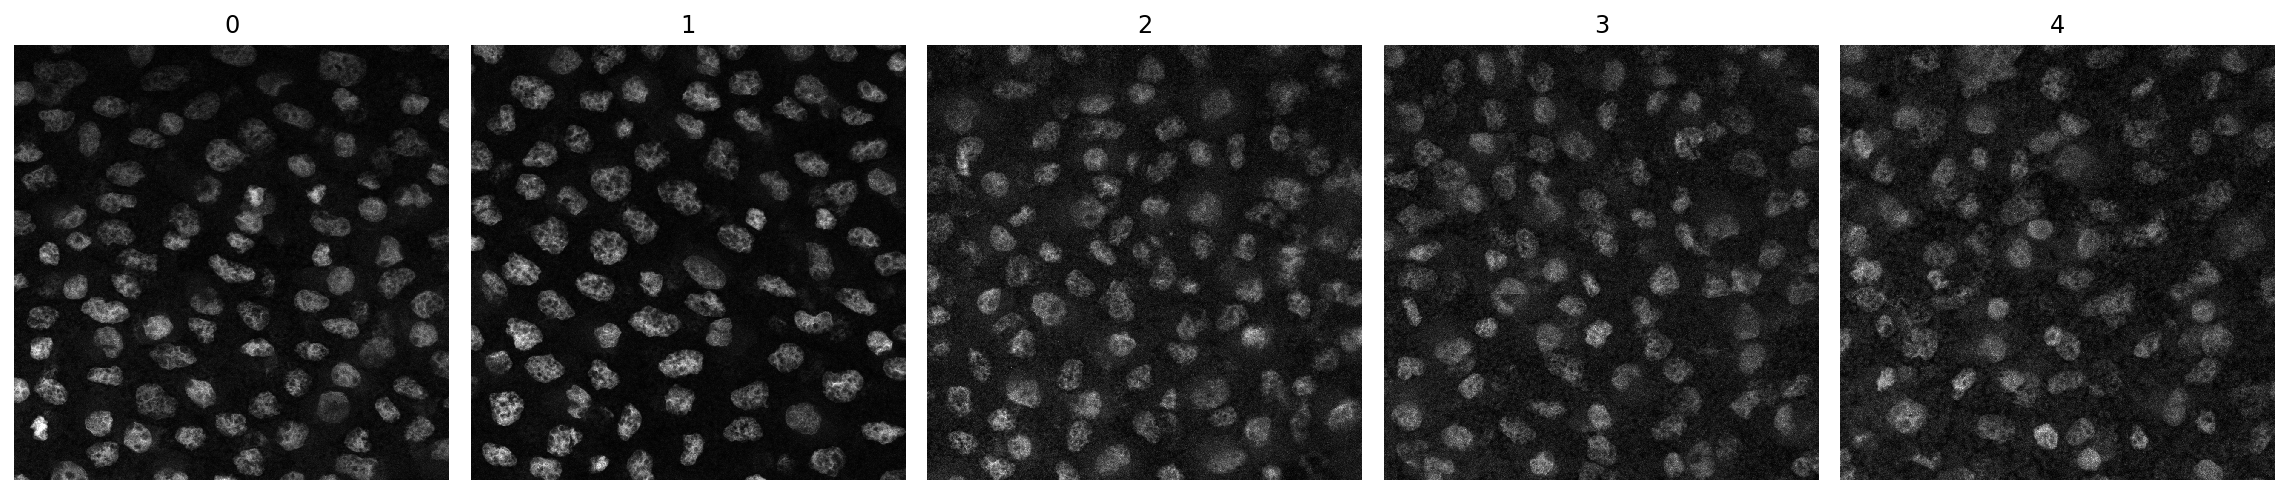

In [33]:
# show all test images
if True:
    fig, ax = plt.subplots(1,5, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [8]:
# demo_model = False

# if demo_model:
#     print (
#         "NOTE: This is loading a previously trained demo model!\n"
#         "      Please set the variable 'demo_model = False' to load your own trained model.",
#         file=sys.stderr, flush=True
#     )
#     model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
# else:
#     model = StarDist2D(None, name='stardist_tune', basedir='tune5_c0_csbsub')
# None;

/home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.46396, nms_thresh=0.4.


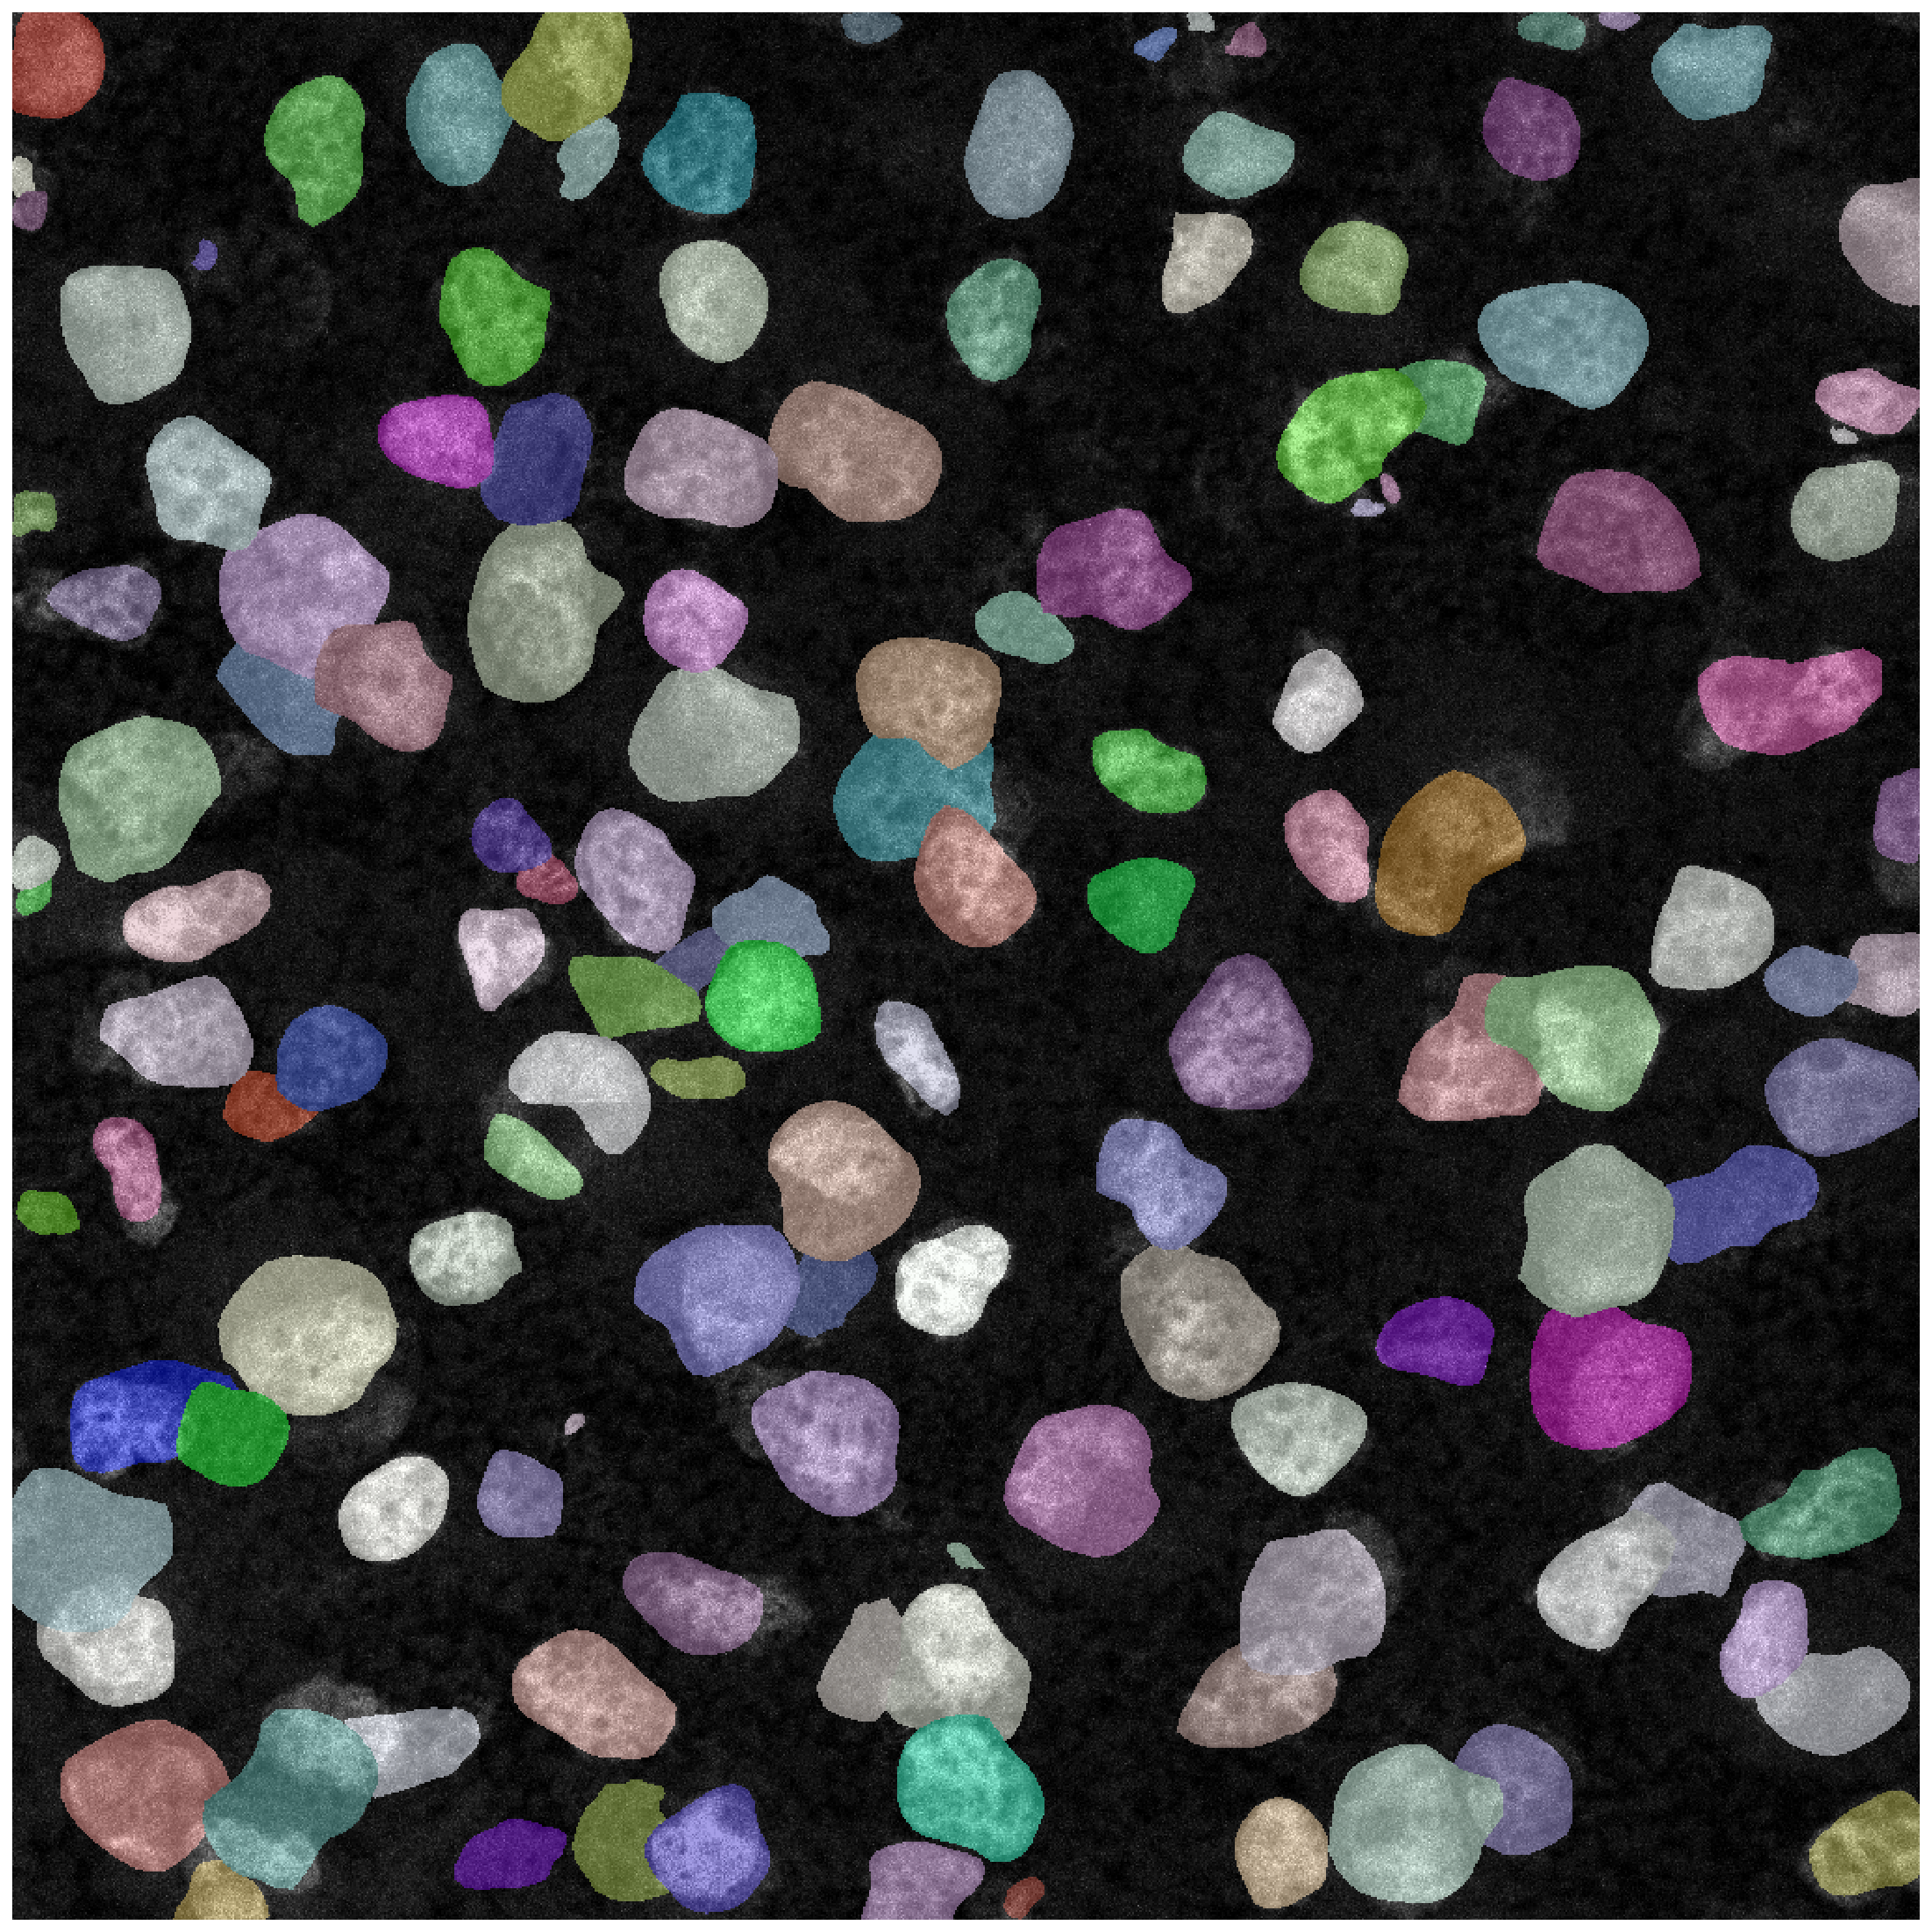

In [45]:
img = normalize(X[3], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

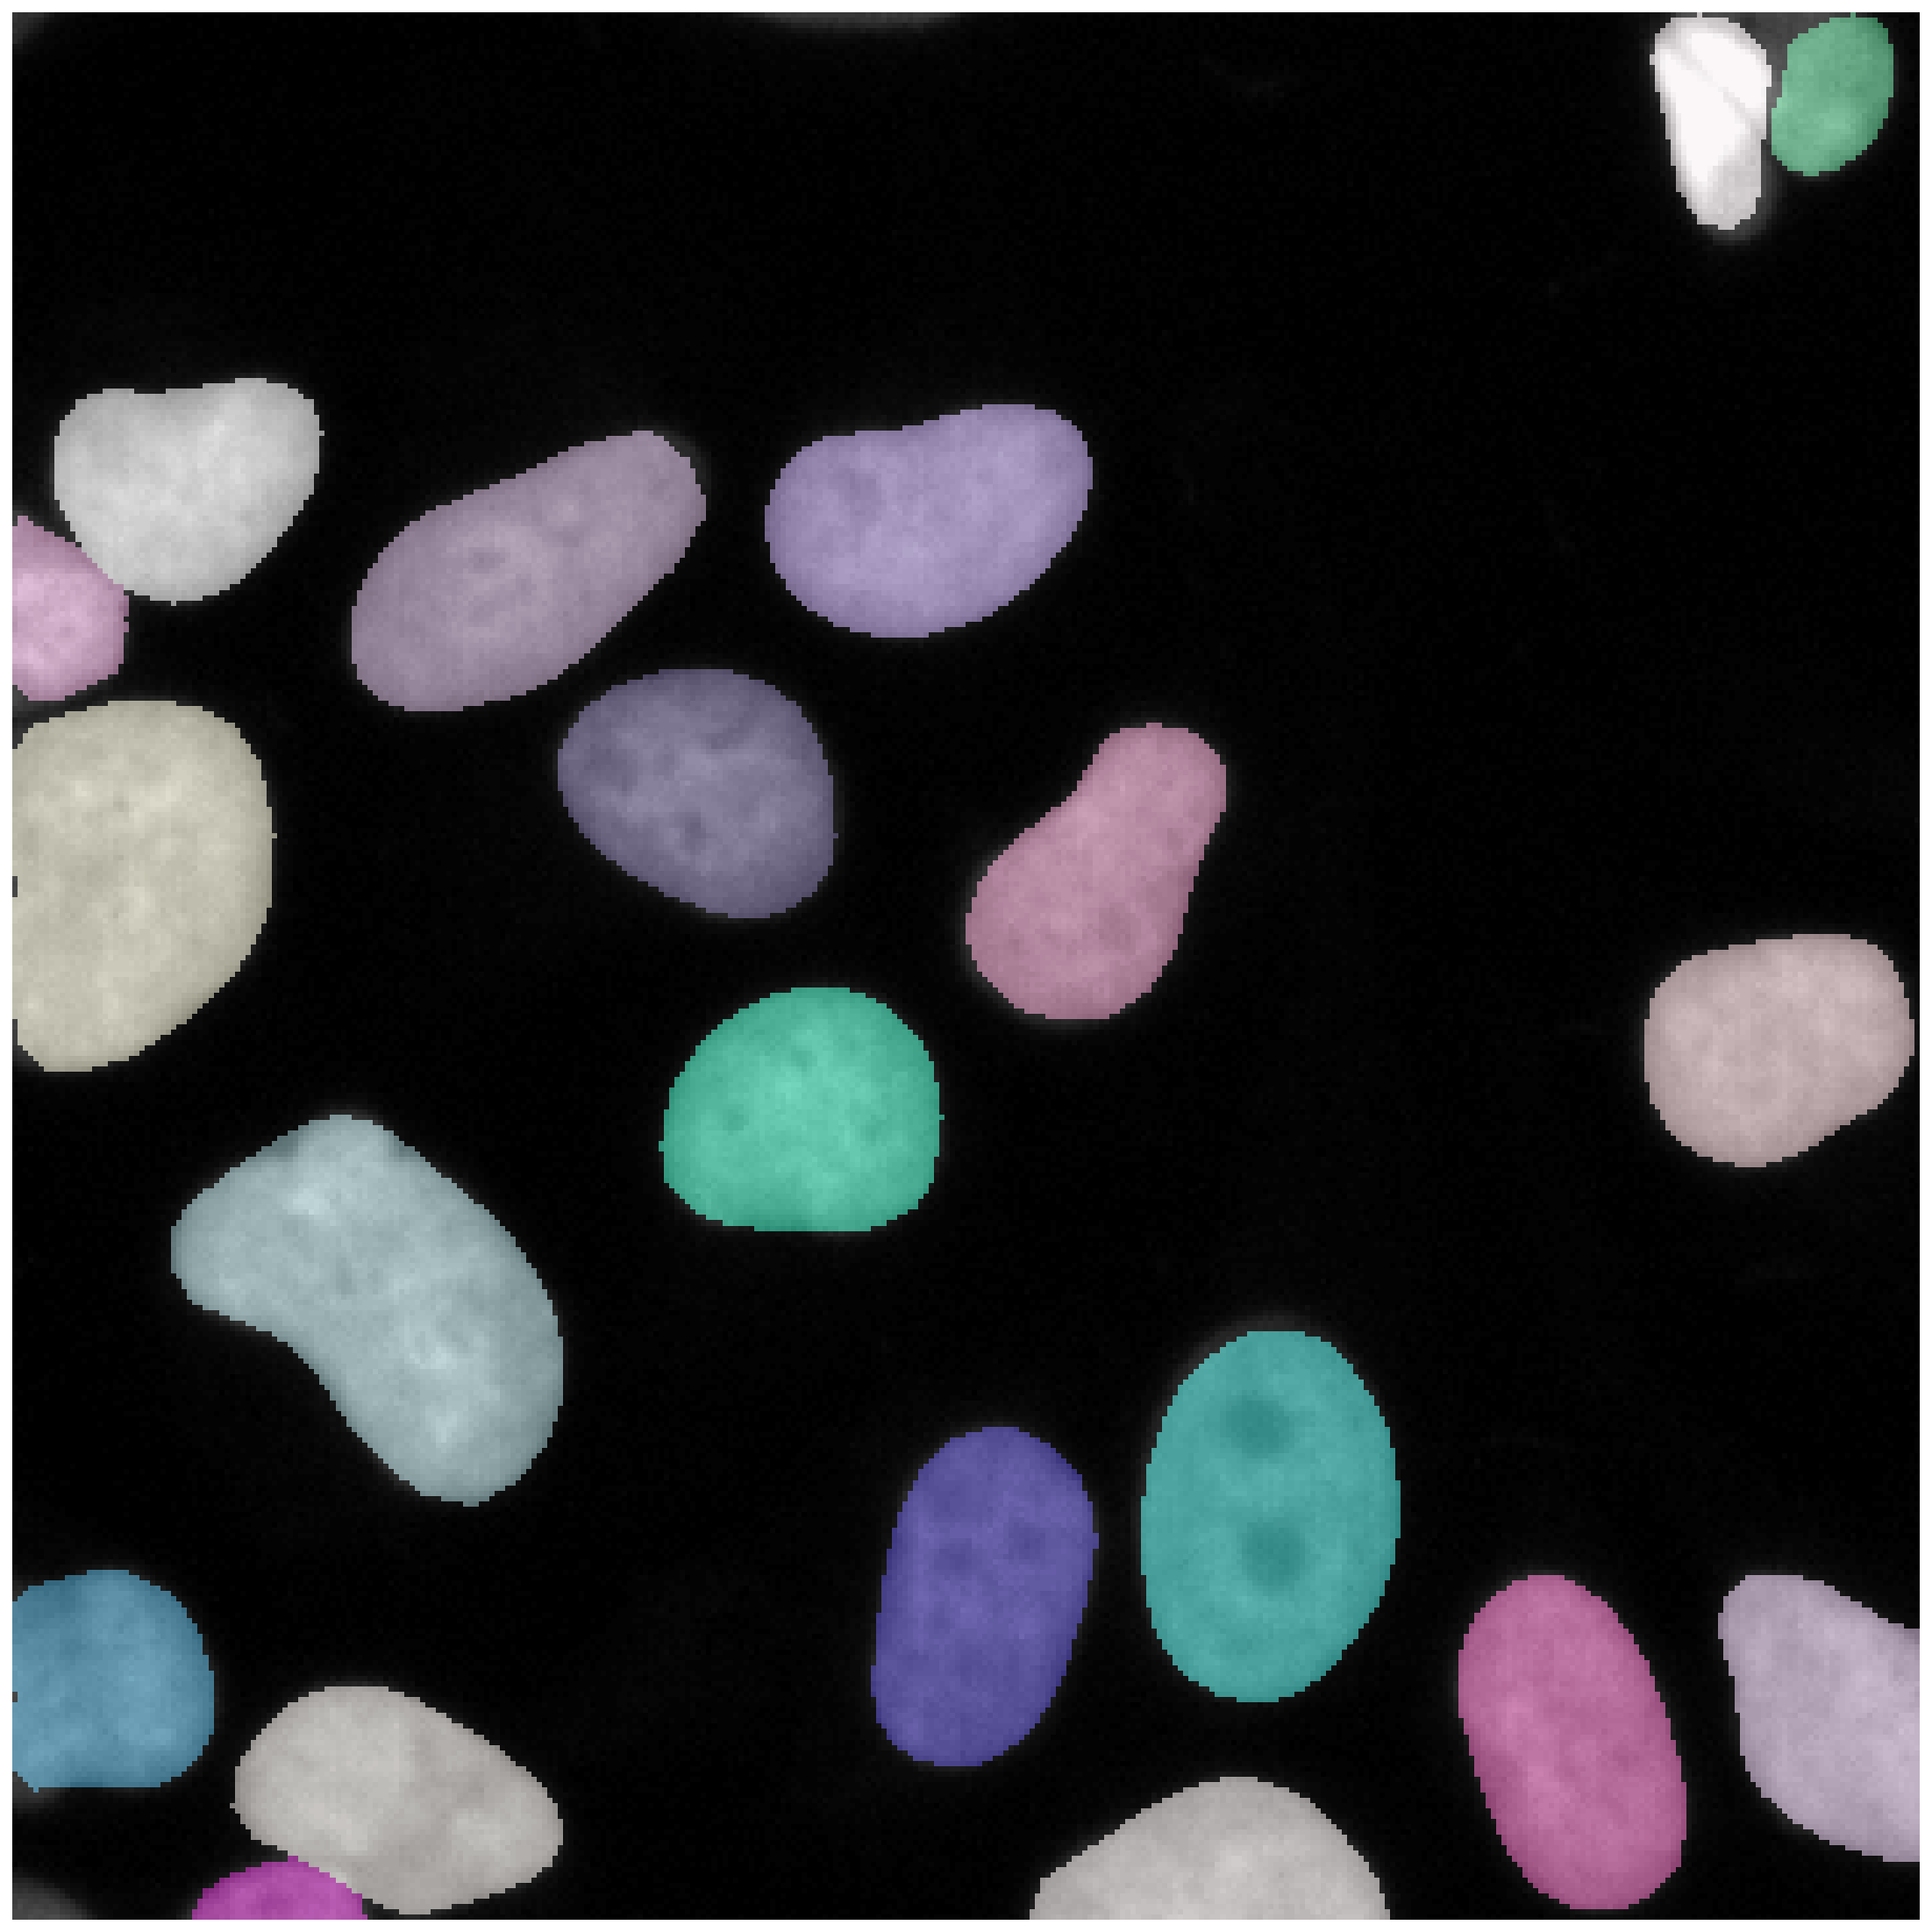

In [43]:
img = normalize(X_val[20], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [12]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

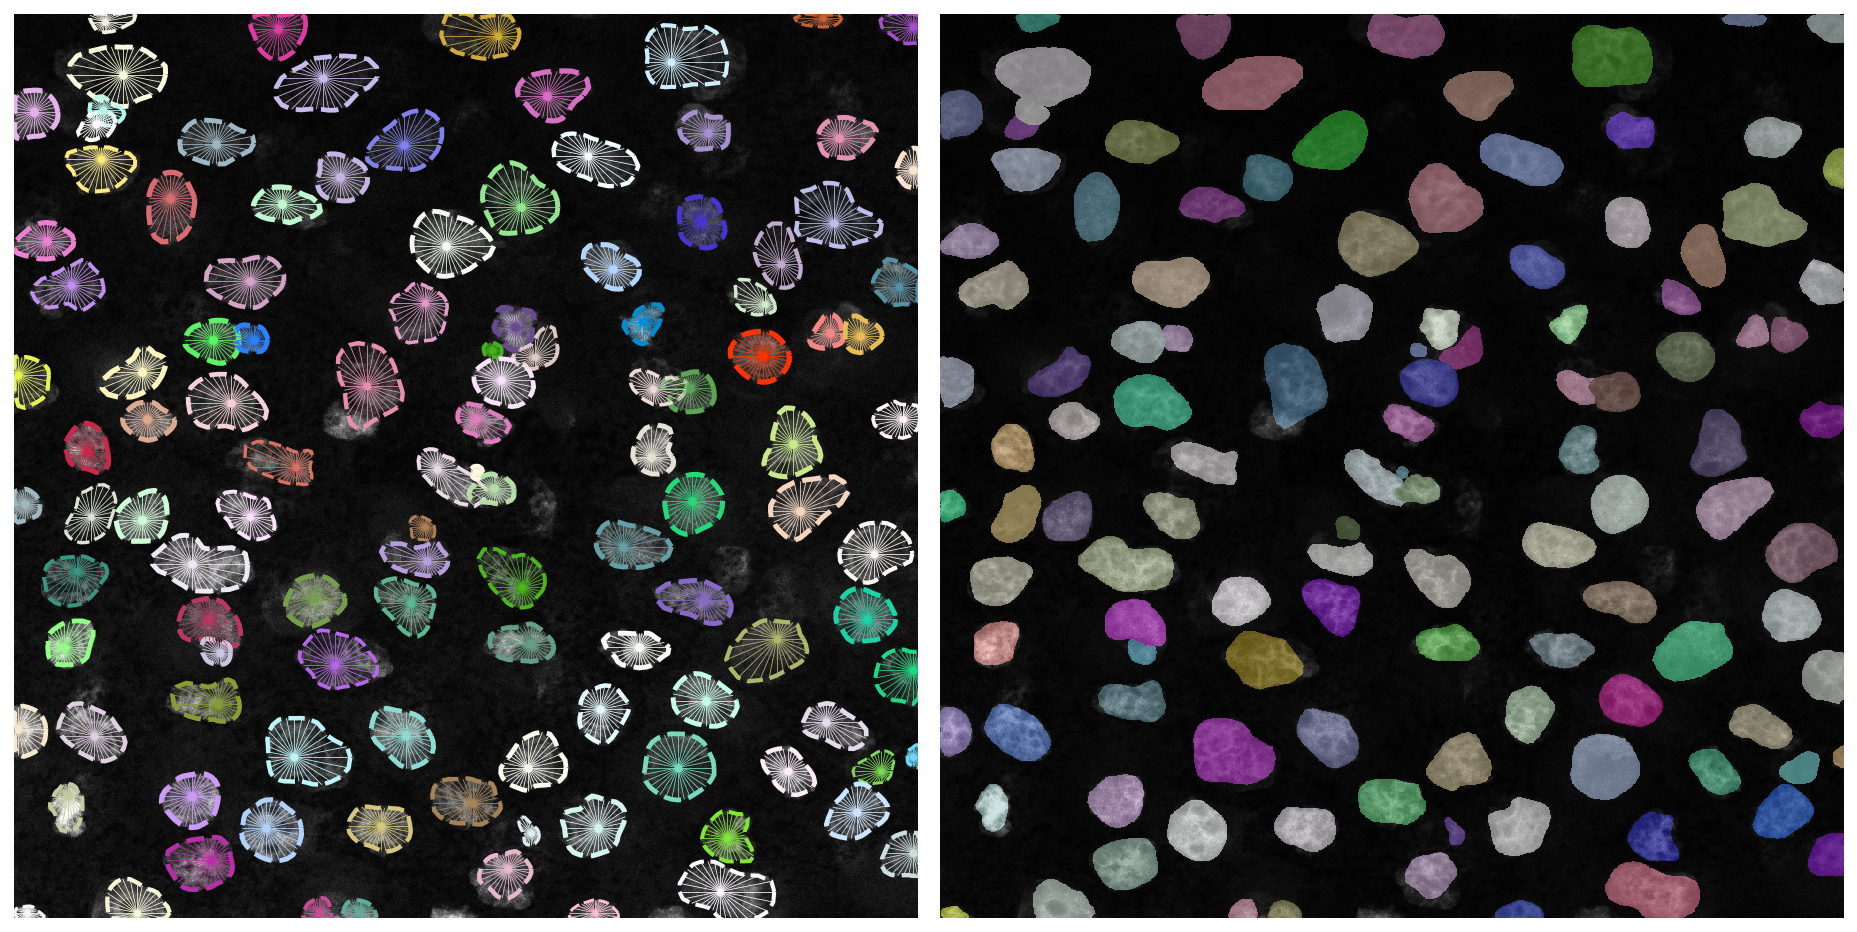

In [14]:
example(model, 0)